# OpenCV Face Detection

In this notebook, opencv face detection will be applied to both HDMI input and webcam images.

To run all cells in this notebook a webcam, HDMI input source and HDMI output monitor are required.  

References:

https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml

## 1. Face Detection on a HDMI Frame
### Step 1: Load the overlay

In [1]:
from pynq import Overlay
Overlay("base.bit").download()

### Step 2: Initialize HDMI I/O

In [2]:
from pynq.drivers.video import HDMI
hdmi_out = HDMI('out')
hdmi_in = HDMI('in', init_timeout=10, frame_list=hdmi_out.frame_list)
hdmi_out.mode(4) # 1920x1080@60Hz
hdmi_in.start()
hdmi_out.start()

### Step 3:Show input frame using IPython Image
Source: http://www.gardnerproductions.ca/wp-content/uploads/2015/10/bigstock-People-with-different-emotions-102991475.jpg

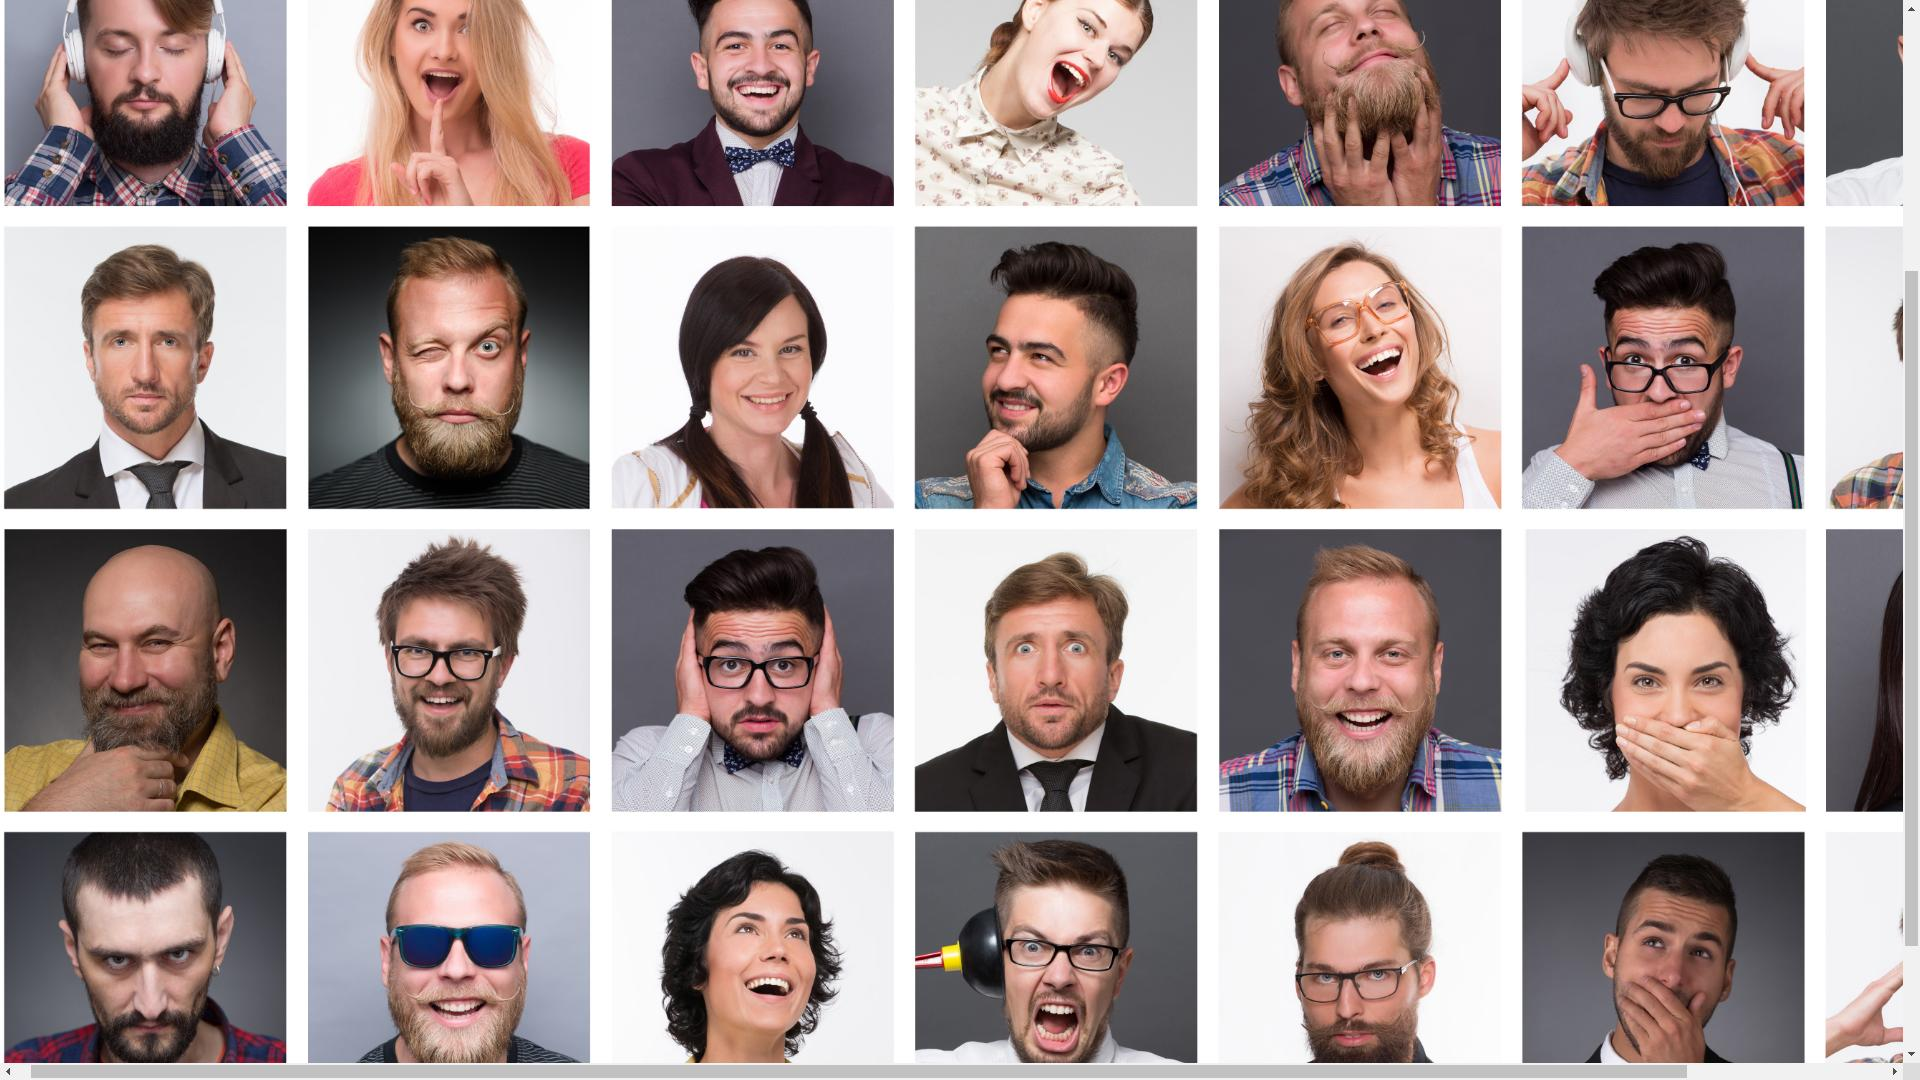

In [3]:
from IPython.display import Image
frame = hdmi_in.frame()
orig_img_path = '/home/xilinx/jupyter_notebooks/Examples/data/face_detect.jpg'
frame.save_as_jpeg(orig_img_path)

Image(filename=orig_img_path)

### Step 4: Apply the face detection to the input

In [4]:
import cv2
import numpy as np

frame = hdmi_in.frame_raw()
np_frame= (np.frombuffer(frame, dtype=np.uint8)).reshape(1080,1920,3)

face_cascade = cv2.CascadeClassifier(
                    './data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(
                    './data/haarcascade_eye.xml')

gray = cv2.cvtColor(np_frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(np_frame,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = np_frame[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

### Step 5: Disconnect HDMI out from HDMI in
The `hdmi_in` will now stream to different frame buffer (no longer connected to `hdmi_out`).

In [5]:
hdmi_in.frame_index_next()

1

### Step 6: Show results on HDMI output
Output OpenCV results via HDMI.

In [6]:
hdmi_out.frame_raw(bytearray(np_frame))

### Step 7: Show results within notebook
Output OpenCV results as JPEG.

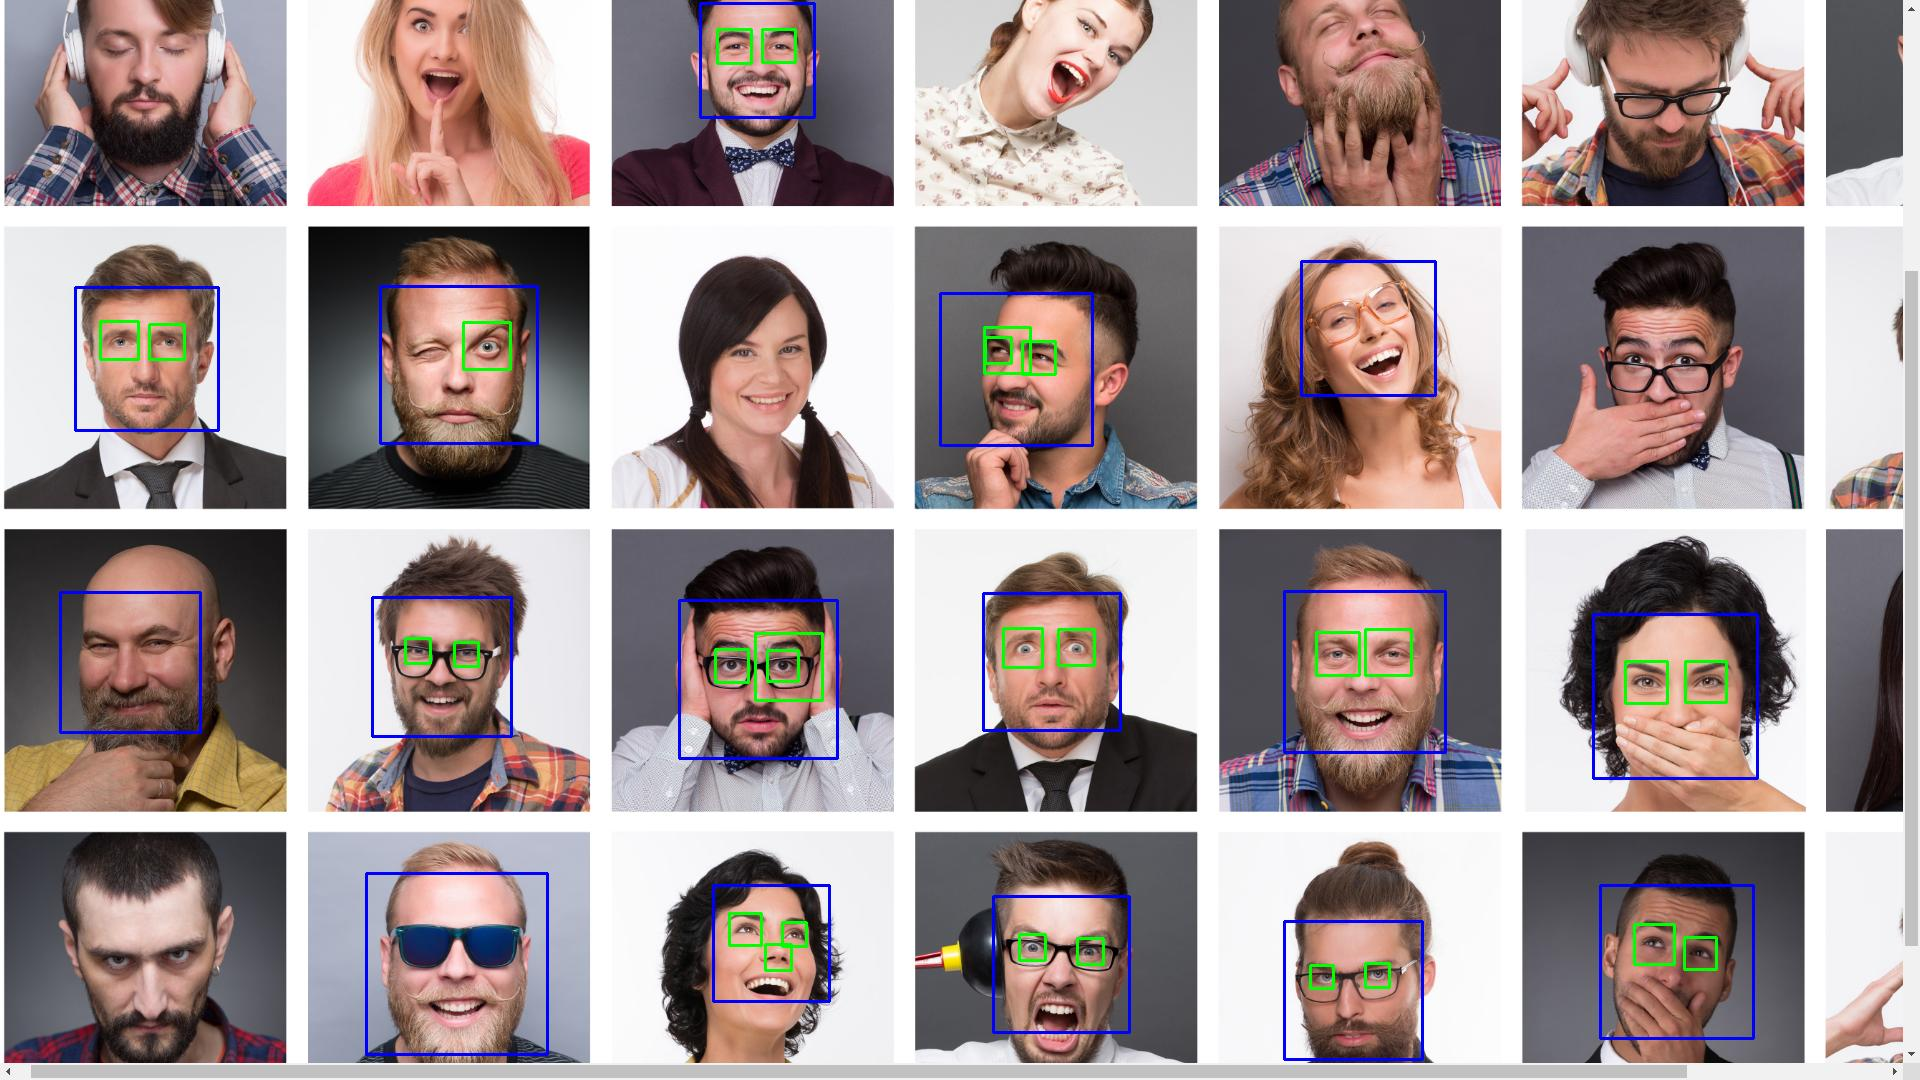

In [7]:
orig_img_path = '/home/xilinx/jupyter_notebooks/Examples/data/face_detect.jpg'
hdmi_out.frame().save_as_jpeg(orig_img_path)
Image(filename=orig_img_path)

## 2. Face Detection on Webcam Frame

### Step 1: Initialize Webcam and set HDMI Out resolution

In [8]:
# monitor configuration: 640*480 @ 60Hz
hdmi_out.mode(0)
hdmi_out.start()
# monitor (output) frame buffer size
frame_out_w = 1920
frame_out_h = 1080
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

In [12]:
# initialize camera from OpenCV
from pynq.drivers.video import Frame
import cv2

videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);

print("capture device is open: " + str(videoIn.isOpened()))

capture device is open: True


### Step 2: Show input frame on HDMI output

In [13]:
# Capture webcam image
import numpy as np

ret, frame_vga = videoIn.read()

# Display webcam image via HDMI Out
if (ret):
    frame_1080p = np.zeros((1080,1920,3)).astype(np.uint8)       
    frame_1080p[0:480,0:640,:] = frame_vga[0:480,0:640,:]
    hdmi_out.frame_raw(bytearray(frame_1080p.astype(np.int8)))
else:
    print("Error while reading from camera")

### Step 3: Now use matplotlib to show image inside notebook

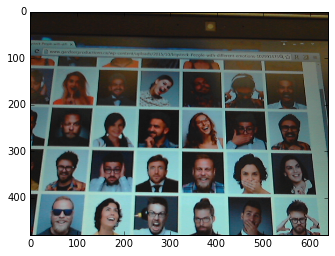

In [14]:
# Output webcam image as JPEG
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(frame_vga[:,:,[2,1,0]])
plt.show()

### Step 4: Apply the face detection to the input

In [15]:
import cv2

np_frame = frame_vga

face_cascade = cv2.CascadeClassifier(
                        './data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(
                        './data/haarcascade_eye.xml')

gray = cv2.cvtColor(np_frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(np_frame,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = np_frame[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

### Step 5: Show results on HDMI output

In [16]:
# Output OpenCV results via HDMI
frame_1080p[0:480,0:640,:] = frame_vga[0:480,0:640,:]
hdmi_out.frame_raw(bytearray(frame_1080p.astype(np.int8)))

### Step 6: Now use matplotlib to show image inside notebook

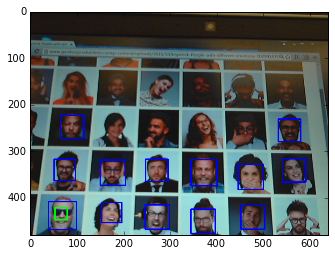

In [17]:
# Output OpenCV results via matplotlib
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(np_frame[:,:,[2,1,0]])
plt.show()

### Step 7: Release camera and HDMI

In [18]:
videoIn.release()
hdmi_out.stop()
hdmi_in.stop()
del hdmi_in, hdmi_out